In [1]:
import pandas as pd
import numpy as np
import random
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy as np
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def loadDataAsDF(path):
    return pd.read_csv(path)

In [3]:
def extractTrainAndValidationData(path):
    df = loadDataAsDF(path)
    df_class_0 = df.loc[df['Class'] == 0]
    df_class_1 = pd.concat([df.loc[df['Class'] == 1]]*500, ignore_index=True)
    
    df_class_0_train = df_class_0[0:int(len(df_class_0)/2)]
    df_class_0_val = df_class_0[int(len(df_class_0)/2):]
    
    df_class_1_train = df_class_1[0:int(len(df_class_1)/2)]
    df_class_1_val = df_class_1[int(len(df_class_1)/2):]
    return (df_class_0_train, df_class_0_val, df_class_1_train, df_class_1_val)

In [4]:
def normalizeDF(df):
    return (df - df.mean())/(df.max() - df.min())

In [5]:
def randomSample(df, n):
    return df.sample(frac=n)

In [6]:
def removeTarget(df):
    return df.drop(['Class', 'Amount'], axis=1)

In [7]:
def createSamples(df_class0, df_class1):
    return pd.concat([randomSample(df_class0,1), randomSample(df_class1,1)])

In [8]:
def createTrainSample(df_class_0_val, df_class_1_val):
    df = createSamples(df_class_0_val, df_class_1_val)
    train_without_target = normalizeDF(removeTarget(df))
    train_target = df['Class']
    return (train_without_target, train_target)

In [9]:
def createTestSamples(df_class_0_val, df_class_1_val):
    test_df = createSamples(df_class_0_val, df_class_1_val)
    test_df_without_target = normalizeDF(removeTarget(test_df))
    test_df_target = test_df['Class']
    return(test_df_without_target, test_df_target)

In [10]:
def runKFold(train_input, train_target, batchSize, epochs):
    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cvscores = []
    model = Sequential()
    model.add(Dense(12, input_dim=29, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    for train, test in kfold.split(train_input.values, train_target.values):
      # create model
        # Fit the model
        model.fit(train_input.values[train], train_target.values[train], epochs=epochs, batch_size=batchSize, verbose=0)
        # evaluate the model
        scores = model.evaluate(train_input.values[test], train_target.values[test], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    return model

In [11]:
def assignClass(x):
    if x > 0.25:
        return 1
    else:
        return 0
assignClassLamda = np.vectorize(assignClass)

In [12]:
def plotRocCurve(fpr, tpr, roc_auc):
    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2F' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

acc: 97.61%
acc: 99.34%
acc: 99.73%
acc: 99.79%
acc: 99.86%
acc: 99.89%
acc: 99.92%
acc: 99.94%
acc: 99.92%
acc: 99.92%
99.59% (+/- 0.68%)


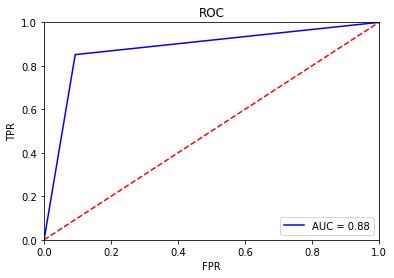

In [13]:
(df_class_0_train, df_class_0_val, df_class_1_train, df_class_1_val) = extractTrainAndValidationData('./data/creditcard.csv')
(train_input, train_target) = createTrainSample(df_class_0_train, df_class_1_train)
model = runKFold(train_input, train_target, 1000, 20)
(test_df_without_target, test_df_target) = createTestSamples(df_class_0_val, df_class_1_val)
predicted_result = assignClassLamda(model.predict(test_df_without_target.values))
sklearn.metrics.confusion_matrix(test_df_target.values, predicted_result, labels=None, sample_weight=None)
fpr, tpr, threshold = metrics.roc_curve(test_df_target.values, predicted_result)
roc_auc = metrics.auc(fpr, tpr)
plotRocCurve(fpr, tpr, roc_auc)